In [60]:
import subprocess
import soundfile as sf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import re
import numpy as np
import csv

### Funciones definidas

#### Funciones de MPTK

In [61]:
# Descomposicion con Matching Pursuit
def run_mpd(dictionary, signal_add, book_add, residual_add, n_atoms, snr):
    # Comandos a ejecutar
    commands = [
        r"cd 'C:\Program Files (x86)\MPTK\bin'",
        r"$Env:MPTK_CONFIG_FILENAME='C:\Program Files (x86)\MPTK\bin\path.xml'",
        f"./mpd -d '{dictionary}' -n {n_atoms} -s {snr} '{signal_add}' '{book_add}' '{residual_add}'"
    ]

    # Unir los comandos y ejecutar
    combined_command = 'powershell.exe -Command "' + ' ; '.join(commands) + '"'
    process = subprocess.run(combined_command, capture_output=True, text=True, shell=True)

    # Imprimir la salida
    print("Output/Error:\n", process.stdout, process.stderr)
    if process.returncode != 0:
        print(f"Error executing command: {combined_command}")

    # Extraer valores de la salida
    initial_energy = re.search(r"The initial signal energy is\s*:\s*([\d.]+)", process.stderr)
    residual_energy = re.search(r"The residual energy is now\s*\[\s*([\d.]+)\s*\]", process.stderr)
    final_snr = re.search(r"The SNR is now\s*\[\s*([\d.]+)\s*\]", process.stderr)

    # Convertir los valores a float 
    initial_energy = float(initial_energy.group(1)) if initial_energy else None
    residual_energy = float(residual_energy.group(1)) if residual_energy else None
    final_snr = float(final_snr.group(1)) if final_snr else None

    return initial_energy, residual_energy, final_snr

# Reconstruccion con Matching Pursuit
def run_mpr(book_add, reconstructed_add, residual_add = None):
    # Comandos a ejecutar
    commands = [
        r"cd 'C:\Program Files (x86)\MPTK\bin'",
        r"$Env:MPTK_CONFIG_FILENAME='C:\Program Files (x86)\MPTK\bin\path.xml'"
    ]

    if residual_add is not None:
        commands.append(f"./mpr '{book_add}' '{reconstructed_add}' '{residual_add}'")
    else:
        commands.append(f"./mpr '{book_add}' '{reconstructed_add}'")

    # Unir los comandos y ejecutar
    combined_command = 'powershell.exe -Command "' + ' ; '.join(commands) + '"'
    process = subprocess.run(combined_command, capture_output=True, text=True, shell=True)

    # Imprimir la salida
    print("Output/Error:\n", process.stdout, process.stderr)
    if process.returncode != 0:
        print(f"Error executing command: {combined_command}")

#### Funciones para Analisis de Atomos

In [62]:
# Editar el archivo XML
def clean_xml(book_file_path):
    with open(book_file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()

    # Encontrar la linea donde comienza el bloque <book>
    start_index = None
    for i, line in enumerate(lines):
        if line.strip().startswith('<book'):
            start_index = i
            break

    if start_index is not None:
        # Mantener la primera linea
        cleaned_lines = [lines[0]] + lines[start_index:]

        # Reescribir el libro limpio
        with open(book_file_path, 'w', encoding='ISO-8859-1') as file:
            file.writelines(cleaned_lines)

# Definir parametros y atributos de los atomos
def set_param(book_file_path, Si, dictionary, n_atoms, snr):
    tree = ET.parse(book_file_path)
    root = tree.getroot()
    # Obtener los resultados del libro en la descomposicion
    initial_energy = float(root.find("param[@name='initialEnergy']").get('value'))
    residual_energy = float(root.find("param[@name='residualEnergy']").get('value'))
    snr_f = float(root.find("param[@name='SNR']").get('value'))
    nAtoms = int(root.get("nAtom"))
    
    atoms = []
    for atom in root.findall('atom'):
        type = atom.get('type')
        num_chans = int(atom.find("par[@type='numChans']").text)
        pos = int(atom.find("support[@chan='0']/p").text)
        len = int(atom.find("support[@chan='0']/l").text)
        amp = float(atom.find("par[@type='amp'][@chan='0']").text)
        freq = float(atom.find("par[@type='freq']").text)
        chirp = float(atom.find("par[@type='chirp']").text)
        phase = float(atom.find("par[@type='phase'][@chan='0']").text)
        window_type = atom.find("window").get('type')
        window_opt = int(atom.find("window").get('opt'))

        atoms.append({
            'type': type,
            'num_chans': num_chans,
            'pos': pos,
            'len': len,
            'amp': amp,
            'freq': freq,
            'chirp': chirp,
            'phase': phase,
            'window_type': window_type,
            'window_opt': window_opt,
            'nAtoms': nAtoms,
            'maxAtoms': n_atoms,
            'SNRf': snr_f,
            'SNR': snr,
            'initialEnergy': initial_energy,
            'residualEnergy': residual_energy,
            'dictionary': dictionary,
            'S': Si
        })
    return atoms

# Agregar los valores al archivo XML
def add_to_xml(book_add, initial_energy, residual_energy, snr):
    # Parsear el archivo XML
    tree = ET.parse(book_add)
    root = tree.getroot()
    
    # Crear los nuevos elementos <param>
    param_initial_energy = ET.Element("param", name="initialEnergy", value=str(initial_energy))
    param_residual_energy = ET.Element("param", name="residualEnergy", value=str(residual_energy))
    param_snr = ET.Element("param", name="SNR", value=str(snr))
    
    # Insertar los nuevos elementos justo después del nodo <book> y antes de los <atom>
    root.insert(0, param_snr)
    root.insert(0, param_residual_energy)
    root.insert(0, param_initial_energy)
    
    # Guardar el archivo XML modificado
    tree.write(book_add)

# Construir un atomo gaussiano
def gaussian_atom(position, length, amplitude, frequency, phase, chirp, size):
    x = np.zeros((size,))
    t = np.arange(length)
    modulation = np.cos(2 * np.pi * (chirp * (t**2)/2 + frequency * t) + phase)

    t = t - (length - 1)/2
    sigma = 0.04 * ((length + 1)**2)
    sigma_G = 1/sigma
    window = np.exp(-sigma_G * (t**2))

    energy_w = np.sqrt(np.sum(window**2))
    window = window/energy_w
    atom = amplitude * window * modulation
    x[position - 1 : position + length - 1] = atom
    return x, atom

# Escribir archivo CSV
def atoms_to_csv(atoms, csv_file_path):
    fieldnames = ['type', 'num_chans', 'pos', 'len', 'amp', 'freq', 'chirp', 'phase', 'window_type', 'window_opt', 
                  'nAtoms', 'maxAtoms', 'SNRf', 'SNR', 'initialEnergy', 'residualEnergy', 'dictionary', 'S']
    exists = os.path.isfile(csv_file_path)

    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Escribir header si no existe el CSV
        if not exists:
            writer.writeheader()

        for atom in atoms:
            writer.writerow(atom)

#### Funciones para graficar

In [63]:
# Graficar los resultados de mptk
def plot_results_mptk(original_signal, reconstructed_signal, noise):
    plt.figure(figsize=(12, 6))
    y_min = min(min(original_signal), min(reconstructed_signal))
    y_max = max(max(original_signal), max(reconstructed_signal))

    plt.subplot(3, 1, 1)
    plt.plot(original_signal, label='Signal')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(reconstructed_signal, label='MPTK Reconstructed')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(noise, label='Noise')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.show()

# Graficar los atomos
def plot_results_atoms(atoms, size):
    plt.figure(figsize=(10, 6))
    for atom in atoms:
        x, y = gaussian_atom(atom['pos'], atom['len'], atom['amp'], atom['freq'], atom['phase'], atom['chirp'], size)
        plt.plot(x)
    
    plt.title("Atomos Gaussianos")
    plt.xlabel("Posicion")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

# Crear reconstruccion manual y graficar
def manual_recons_plot(atoms, size):
    plt.figure(figsize=(10, 6))
    s = np.zeros((size,))
    
    for atom in atoms:
        x, y = gaussian_atom(atom['pos'], atom['len'], atom['amp'], atom['freq'], atom['phase'], atom['chirp'], size)
        s += x
    
    # Graficar
    plt.plot(s, label="Manual Reconstructed")
    plt.xlabel("Posicion")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()
    return s

# Graficar y comparar la reconstruccion manual
def plot_results_manual(original_signal, reconstructed_signal, manual_rec, error, error1):
    plt.figure(figsize=(12, 6))
    y_min = min(min(original_signal), min(reconstructed_signal))
    y_max = max(max(original_signal), max(reconstructed_signal))

    plt.subplot(5, 1, 1)
    plt.plot(original_signal, label='Signal')
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(reconstructed_signal, label='MPTK Reconstructed')
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(manual_rec, label='Manual Reconstructed')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(error, label='Error m-r')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.subplot(5, 1, 5)
    plt.plot(error1, label='Error m-o')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.show()

# Single Audio Matching Pursuit (MPTK)

### Especificar direcciones y archivos

In [64]:
# Especificar parametros y diccionario (MPTK)
dictionary = "dic_gabor_v3.xml" 
Si = "S1"
test = "7"
filename = "New_N_144_5_S1.wav"
n = 50  # Numero de atomos
s = 30 # SNR 

# Señal original 
signal_add = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\{Si}\{filename}"
original_signal, sr = sf.read(signal_add)
size = len(original_signal)
# Libro .xml con los atomos seleccionados en la descomposicion
book_add = fr'c:\Users\Juan Carlos\Documents\DSP\Test{test}\Book_{Si}\book_{filename}.xml'
# Archivo .wav con el residuo obtenido
residual_add = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\Noise\residual_{filename}.wav"
# Archivo .wav con la señal reconstruida
reconstructed_add = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\Reconstructed_{Si}\reconstructed_{filename}.wav"

### Ejecutar MPTK

In [65]:
# Descomposicion
print(size)
E_i, E_res, snr_f = run_mpd(dictionary, signal_add, book_add, residual_add, n, s)
# Reconstrucion
run_mpr(book_add, reconstructed_add) # Agregar residual_add si se requiere

# Limpiar y agregar parametros al book
clean_xml(book_add)
add_to_xml(book_add, E_i, E_res, snr_f)

1512
Output/Error:
  mptk WARNING -- mpd - The option --num-iter=/--num-atoms= was specified together with the option --snr=.
mptk WARNING -- mpd - The algorithm will stop when the first of either conditions is reached.
mptk WARNING -- mpd - (Use --help to get help if this is not what you want.)
mptk INFO -- mpd - ------------------------------------
mptk INFO -- mpd - MPD - MATCHING PURSUIT DECOMPOSITION
mptk INFO -- mpd - ------------------------------------
mptk INFO -- mpd - The command line was:
C:\Program Files (x86)\MPTK\bin\mpd.exe -d dic_gabor_v3.xml -n 50 -s 30 c:\Users\Juan Carlos\Documents\DSP\Test7\S1\New_N_144_5_S1.wav c:\Users\Juan Carlos\Documents\DSP\Test7\Book_S1\book_New_N_144_5_S1.wav.xml c:\Users\Juan Carlos\Documents\DSP\Test7\Noise\residual_New_N_144_5_S1.wav.wav 
mptk INFO -- mpd - End command line.
mptk INFO -- mpd - Loading the dictionary...
mptk INFO -- mpd - (In the following, spurious output of dictionary pieces would be a symptom of parsing errors.)
mptk I

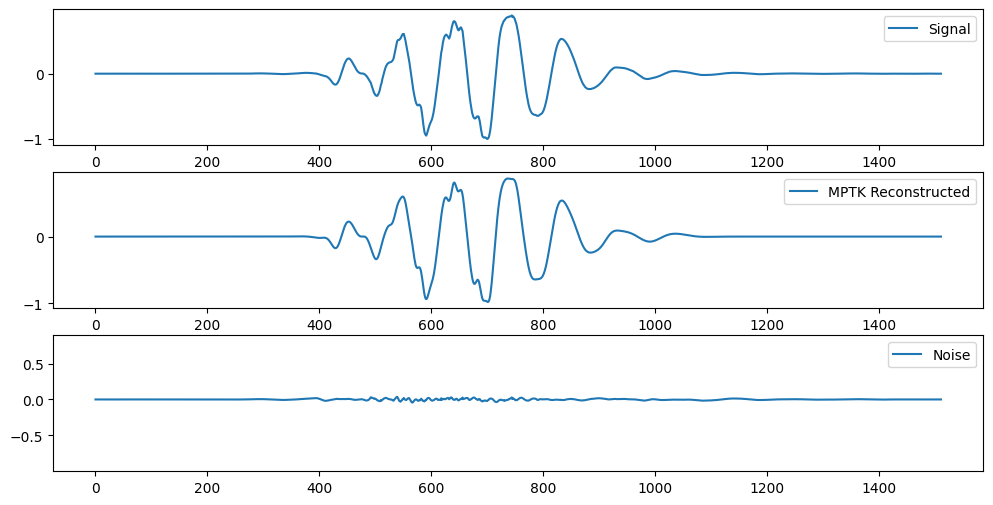

In [67]:
# Graficar
reconstructed_signal, srr = sf.read(reconstructed_add)
noise, srn = sf.read(residual_add)
plot_results_mptk(original_signal, reconstructed_signal, noise)


# Single Book Atoms Analysis

### Definir los atomos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


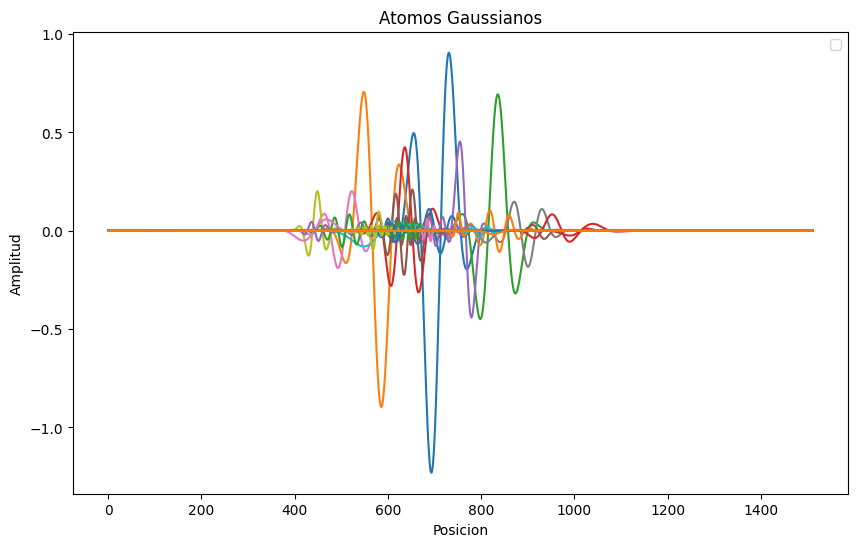

In [68]:
# Direccion para escribir CSV de un solo book (opcional)
csv_file_path = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\AtomsCSV\Atoms_{filename}.csv"

# Procesar el archivo XML
atoms = set_param(book_add, Si, dictionary, n, s)
# Escribir csv
atoms_to_csv(atoms, csv_file_path)

# Imprimir
# for atom in atoms:
#     print(atom, "\n")
# Graficar
plot_results_atoms(atoms, size)

### Reconstruccion Manual

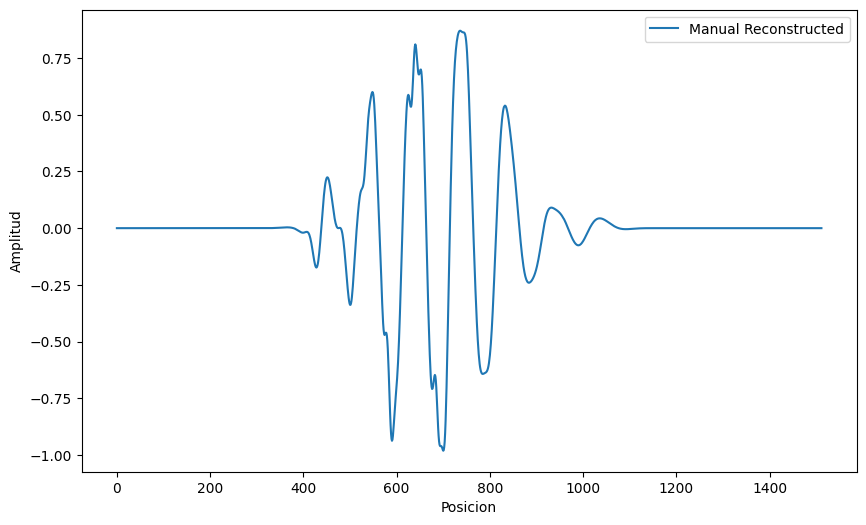

1512


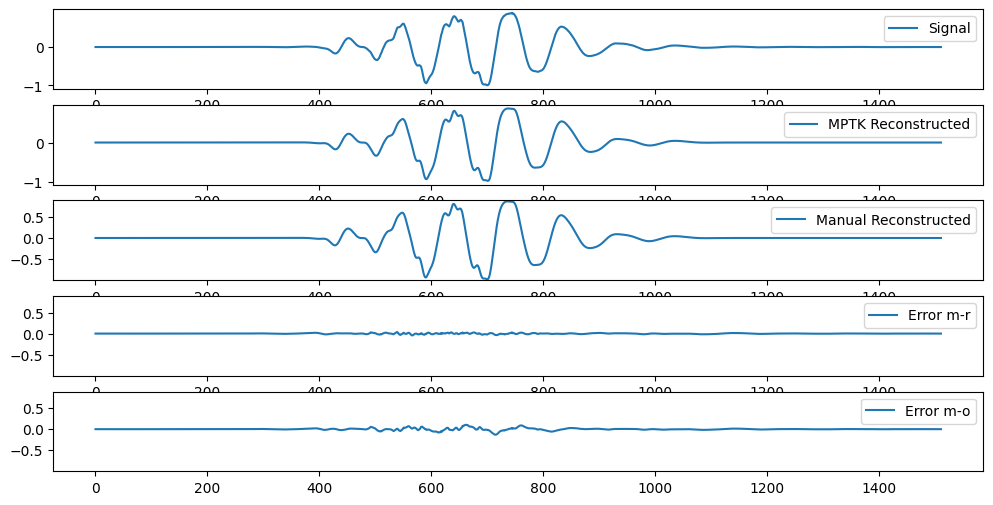

In [70]:
# Crear reconstruccion
s = manual_recons_plot(atoms, size)
# Graficar
plot_results_manual(original_signal, reconstructed_signal, s, noise, original_signal - s)